In [6]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path
import re

In [7]:
def parse_txt_file(txt_path):
    """Parse the .txt file to extract subject metadata."""
    data = {}
    
    with open(txt_path, 'r') as f:
        content = f.read()
    
    patterns = {
        'SESSION_ID': r'SESSION ID:\s+(.+)',
        'AGE': r'AGE:\s+(\d+)',
        'M/F': r'M/F:\s+(\w+)',
        'HAND': r'HAND:\s+(\w+)',
        'EDUC': r'EDUC:\s+(\d+)',
        'SES': r'SES:\s+(\d+)',
        'CDR': r'CDR:\s+([\d.]+)',
        'MMSE': r'MMSE:\s+(\d+)',
        'eTIV': r'eTIV:\s+([\d.]+)',
        'ASF': r'ASF:\s+([\d.]+)',
        'nWBV': r'nWBV:\s+([\d.]+)'
    }
    
    for key, pattern in patterns.items():
        match = re.search(pattern, content)
        if match:
            data[key] = match.group(1)
    
    return data

In [8]:
def parse_xml_file(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    ns = {'xnat': 'http://nrg.wustl.edu/xnat',
          'oasis': 'http://nmr.mgh.harvard.edu/oasis'}
    
    data = {
        'session_id': root.get('ID'),
        'subject_id': root.find('xnat:subject_ID', ns).text if root.find('xnat:subject_ID', ns) is not None else None,
        'scans': [],
        'reconstructions': [],
        'assessors': []
    }
    
    scans = root.find('xnat:scans', ns)
    if scans is not None:
        for scan in scans.findall('xnat:scan', ns):
            scan_data = {
                'scan_id': scan.get('ID'),
                'type': scan.get('type'),
                'quality': scan.find('xnat:quality', ns).text if scan.find('xnat:quality', ns) is not None else None
            }
            
            # Parse parameters
            params = scan.find('xnat:parameters', ns)
            if params is not None:
                voxel_res = params.find('xnat:voxelRes', ns)
                if voxel_res is not None:
                    scan_data['voxel_x'] = voxel_res.get('x')
                    scan_data['voxel_y'] = voxel_res.get('y')
                    scan_data['voxel_z'] = voxel_res.get('z')
                
                scan_data['orientation'] = params.find('xnat:orientation', ns).text if params.find('xnat:orientation', ns) is not None else None
                scan_data['tr'] = params.find('xnat:tr', ns).text if params.find('xnat:tr', ns) is not None else None
                scan_data['te'] = params.find('xnat:te', ns).text if params.find('xnat:te', ns) is not None else None
                scan_data['ti'] = params.find('xnat:ti', ns).text if params.find('xnat:ti', ns) is not None else None
                scan_data['flip'] = params.find('xnat:flip', ns).text if params.find('xnat:flip', ns) is not None else None
            
            data['scans'].append(scan_data)
    
    # Parse assessors
    assessors = root.find('xnat:assessors', ns)
    if assessors is not None:
        for assessor in assessors.findall('xnat:assessor', ns):
            assessor_type = assessor.get('{http://www.w3.org/2001/XMLSchema-instance}type')
            assessor_data = {
                'assessor_id': assessor.get('ID'),
                'type': assessor_type
            }
            
            # Atlas Scaling Factor
            if 'atlasScalingFactorData' in assessor_type:
                scaling_factor = assessor.find('oasis:scalingFactor', ns)
                eicv = assessor.find('oasis:eICV', ns)
                if scaling_factor is not None:
                    assessor_data['scaling_factor'] = scaling_factor.text
                if eicv is not None:
                    assessor_data['eICV'] = eicv.text
            
            # Segmentation data
            if 'segmentationFastData' in assessor_type:
                brain_percent = assessor.get('brainPercent')
                if brain_percent:
                    assessor_data['brain_percent'] = brain_percent
            
            data['assessors'].append(assessor_data)
    
    return data

In [17]:
def process_oasis_dataset(data_dir):
    data_path = Path(data_dir)
    subjects_data = []
    scans_data = []
    assessors_data = []
    
    # Check if path exists
    if not data_path.exists():
        print(f"Error: {data_path} does not exist!")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    # Get all top-level directories
    top_level_dirs = [d for d in data_path.iterdir() if d.is_dir()]
    print(f"Found {len(top_level_dirs)} top-level directories")
    
    for top_dir in top_level_dirs:
        print(f"\nProcessing {top_dir.name}...")
        
        # Look for 'disc1', 'disc2', etc. folders inside
        disc_folders = [d for d in top_dir.iterdir() if d.is_dir() and d.name.lower().startswith('disc')]
        
        if not disc_folders:
            # Maybe subjects are directly in this folder?
            subject_dirs = [d for d in top_dir.iterdir() if d.is_dir() and d.name.startswith('OAS1_')]
            if subject_dirs:
                print(f"  Found {len(subject_dirs)} subjects directly in {top_dir.name}")
                disc_folders = [top_dir]  # Process this directory as if it were a disc folder
            else:
                print(f"  No disc folders or subjects found in {top_dir.name}")
                continue
        else:
            print(f"  Found {len(disc_folders)} disc folders")
        
        for disc_folder in disc_folders:
            # Find all subject directories (OAS1_XXXX_MR1)
            subject_dirs = [d for d in disc_folder.iterdir() if d.is_dir() and d.name.startswith('OAS1_')]
            print(f"    Processing {disc_folder.name}: {len(subject_dirs)} subjects")
            
            for subject_dir in subject_dirs:
                subject_id = subject_dir.name
                txt_file = subject_dir / f"{subject_id}.txt"
                xml_file = subject_dir / f"{subject_id}.xml"
                
                if txt_file.exists() and xml_file.exists():
                    try:
                        txt_data = parse_txt_file(txt_file)
                        xml_data = parse_xml_file(xml_file)
                        
                        subject_record = {**txt_data, 'disc': top_dir.name}
                        subjects_data.append(subject_record)
                        
                        for scan in xml_data['scans']:
                            scan_record = {'subject_id': subject_id, **scan}
                            scans_data.append(scan_record)
                        
                        for assessor in xml_data['assessors']:
                            assessor_record = {'subject_id': subject_id, **assessor}
                            assessors_data.append(assessor_record)
                    except Exception as e:
                        print(f"      Error processing {subject_id}: {e}")
                else:
                    if not txt_file.exists():
                        print(f"      Missing: {txt_file.name}")
                    if not xml_file.exists():
                        print(f"      Missing: {xml_file.name}")
    
    print(f"\n{'='*60}")
    print(f"Total subjects processed: {len(subjects_data)}")
    print(f"Total scans: {len(scans_data)}")
    print(f"Total assessors: {len(assessors_data)}")
    print(f"{'='*60}")
    
    df_subjects = pd.DataFrame(subjects_data)
    df_scans = pd.DataFrame(scans_data)
    df_assessors = pd.DataFrame(assessors_data)
    
    return df_subjects, df_scans, df_assessors

In [11]:
print("\n=== SUBJECTS DATAFRAME ===")
print(df_subjects.head())
print(f"\nShape: {df_subjects.shape}")
print(f"\nColumns: {df_subjects.columns.tolist()}")


=== SUBJECTS DATAFRAME ===
      SESSION_ID AGE     M/F   HAND EDUC  SES  CDR MMSE     eTIV   ASF   nWBV  \
0  OAS1_0001_MR1  74  Female  Right    2    3    0   29  1344.00  1.31  0.743   
1  OAS1_0002_MR1  55  Female  Right    4    1    0   29  1147.00  1.53  0.810   
2  OAS1_0003_MR1  73  Female  Right    4    3  0.5   27  1454.00  1.21  0.708   
3  OAS1_0004_MR1  28    Male  Right  NaN  NaN  NaN  NaN  1588.00  1.11  0.803   
4  OAS1_0005_MR1  18    Male  Right  NaN  NaN  NaN  NaN  1737.00  1.01  0.848   

                           disc  
0  OASIS Cross-Sectional Disc 1  
1  OASIS Cross-Sectional Disc 1  
2  OASIS Cross-Sectional Disc 1  
3  OASIS Cross-Sectional Disc 1  
4  OASIS Cross-Sectional Disc 1  

Shape: (436, 12)

Columns: ['SESSION_ID', 'AGE', 'M/F', 'HAND', 'EDUC', 'SES', 'CDR', 'MMSE', 'eTIV', 'ASF', 'nWBV', 'disc']


In [12]:
print(df_scans.head())
print(f"\nShape: {df_scans.shape}")
print(f"\nColumns: {df_scans.columns.tolist()}")

      subject_id scan_id    type quality voxel_x voxel_y voxel_z orientation  \
0  OAS1_0001_MR1   mpr-1  MPRAGE  usable     1.0     1.0    1.25         Sag   
1  OAS1_0001_MR1   mpr-2  MPRAGE  usable     1.0     1.0    1.25         Sag   
2  OAS1_0001_MR1   mpr-3  MPRAGE  usable     1.0     1.0    1.25         Sag   
3  OAS1_0001_MR1   mpr-4  MPRAGE  usable     1.0     1.0    1.25         Sag   
4  OAS1_0002_MR1   mpr-1  MPRAGE  usable     1.0     1.0    1.25         Sag   

    tr   te    ti flip  
0  9.7  4.0  20.0   10  
1  9.7  4.0  20.0   10  
2  9.7  4.0  20.0   10  
3  9.7  4.0  20.0   10  
4  9.7  4.0  20.0   10  

Shape: (1688, 12)

Columns: ['subject_id', 'scan_id', 'type', 'quality', 'voxel_x', 'voxel_y', 'voxel_z', 'orientation', 'tr', 'te', 'ti', 'flip']


In [13]:
numeric_cols = ['AGE', 'EDUC', 'SES', 'CDR', 'MMSE', 'eTIV', 'ASF', 'nWBV']
for col in numeric_cols:
    if col in df_subjects.columns:
        df_subjects[col] = pd.to_numeric(df_subjects[col], errors='coerce')

scan_numeric_cols = ['voxel_x', 'voxel_y', 'voxel_z', 'tr', 'te', 'ti', 'flip']
for col in scan_numeric_cols:
    if col in df_scans.columns:
        df_scans[col] = pd.to_numeric(df_scans[col], errors='coerce')

assessor_numeric_cols = ['scaling_factor', 'eICV', 'brain_percent']
for col in assessor_numeric_cols:
    if col in df_assessors.columns:
        df_assessors[col] = pd.to_numeric(df_assessors[col], errors='coerce')

print("Data types converted successfully!")

Data types converted successfully!


In [14]:
print("\n=== SUBJECT DEMOGRAPHICS ===")
print(f"\nAge statistics:")
print(df_subjects['AGE'].describe())

print(f"\nGender distribution:")
print(df_subjects['M/F'].value_counts())

print(f"\nCDR (Clinical Dementia Rating) distribution:")
print(df_subjects['CDR'].value_counts().sort_index())


=== SUBJECT DEMOGRAPHICS ===

Age statistics:
count    436.000000
mean      51.357798
std       25.269862
min       18.000000
25%       23.000000
50%       54.000000
75%       74.000000
max       96.000000
Name: AGE, dtype: float64

Gender distribution:
M/F
Female    268
Male      168
Name: count, dtype: int64

CDR (Clinical Dementia Rating) distribution:
CDR
0.0    135
0.5     70
1.0     28
2.0      2
Name: count, dtype: int64


In [15]:
df_subjects.to_csv('oasis_subjects.csv', index=False)
df_scans.to_csv('oasis_scans.csv', index=False)
df_assessors.to_csv('oasis_assessors.csv', index=False)

print("\nDataFrames saved to CSV files:")
print("- oasis_subjects.csv")
print("- oasis_scans.csv")
print("- oasis_assessors.csv")


DataFrames saved to CSV files:
- oasis_subjects.csv
- oasis_scans.csv
- oasis_assessors.csv


1752.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


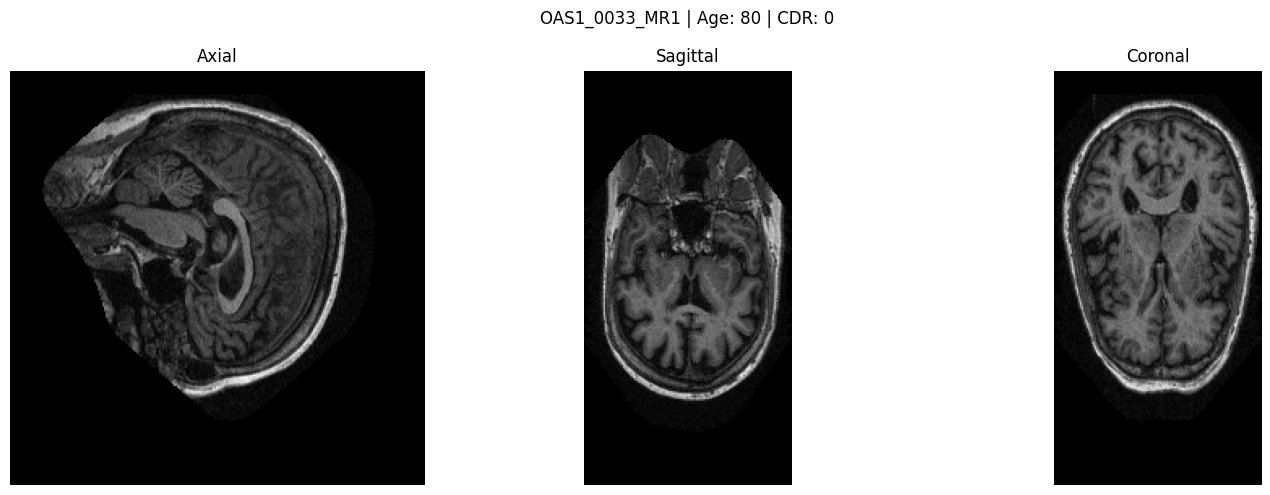

In [22]:
# Run this cell first:
!pip install nibabel matplotlib

# Then use this simple function:
def quick_display(df_subjects, session_id, data_dir='./data'):
    import nibabel as nib
    import matplotlib.pyplot as plt
    from pathlib import Path
    
    subject = df_subjects[df_subjects['SESSION_ID'] == session_id].iloc[0]
    data_path = Path(data_dir) / subject['disc']
    disc_folders = [d for d in data_path.iterdir() if d.is_dir() and d.name.lower().startswith('disc')]
    
    for disc_folder in disc_folders:
        subject_path = disc_folder / session_id
        if subject_path.exists():
            img_file = list((subject_path / 'RAW').glob('*.img'))[0]
            img = nib.load(str(img_file))
            img_data = img.get_fdata()
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(img_data[:, :, img_data.shape[2]//2], cmap='gray')
            axes[0].set_title('Axial')
            axes[0].axis('off')
            
            axes[1].imshow(img_data[img_data.shape[0]//2, :, :], cmap='gray')
            axes[1].set_title('Sagittal')
            axes[1].axis('off')
            
            axes[2].imshow(img_data[:, img_data.shape[1]//2, :], cmap='gray')
            axes[2].set_title('Coronal')
            axes[2].axis('off')
            
            plt.suptitle(f'{session_id} | Age: {subject["AGE"]} | CDR: {subject["CDR"]}')
            plt.tight_layout()
            plt.show()
            return

quick_display(df_subjects, 'OAS1_0033_MR1')